In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
import astropy.constants as const
from scipy.stats import permutation_test

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{mathptmx}",  # Times Roman
    "hatch.linewidth": 3.0,
})
sns.set_context("paper",font_scale=1.5)
sns.set_palette("pastel")


def separate_mag(col):
    m = [list(map(float,a.split("/"))) for a in col]
    bigM = np.array([np.max(m) for m in m])
    smallM = np.array([np.min(m) for m in m])
    return bigM, smallM

# calculate luminosity
def cal_lum(mag,wl,redshifts):
    f = 10**((mag+21.1)/-2.5) *u.erg/u.s/u.cm**2/u.angstrom
    lum = (4*np.pi *cosmo.angular_diameter_distance(redshifts)**2 *f *(wl*u.angstrom)).to(u.erg/u.s)
    return lum


def hist_bin(ax,quant,lab,clr):
    """plot histogram and a straight line at peak bin"""
    try:
        count, bin, _ = ax.hist(quant,bins=np.linspace(quant.min(),quant.max(),int(np.sqrt(len(quant)))),
                histtype='step',color=clr,alpha=0.6)
        maxind = np.argmax(count)
        maxloc = (bin[maxind]+bin[maxind+1])/2
        ax.axvline(maxloc,c=clr,label=lab)
    except:
        ax.axvline(np.mean(quant),c=clr,label=lab)
    
def meas_df(rp,quartiles,quant,ax,dualmask,cuts):
    """plot sep histograms of luminosity bins based on list of quartiles"""
    if cuts == []:
        cuts =  np.percentile(quant,quartiles)
    colors = sns.color_palette("magma", len(cuts)+1)
    for i,c in zip(range(len(cuts)+1),colors):
        if i==0:
            lbl = f'$<$ {cuts[i]:.2f}'
            hist_bin(ax[0],rp[(quant < cuts[i]) & dualmask], lbl, c)
        elif i==len(cuts):
            lbl = f'$>$ {cuts[i-1]:.2f}'
            hist_bin(ax[0],rp[(quant > cuts[i-1]) & dualmask], lbl, c)
        else:
            lbl = f'{cuts[i-1]:.2f} $-$ {cuts[i]:.2f}'
            hist_bin(ax[0],rp[(quant < cuts[i]) & (quant > cuts[i-1]) & dualmask], lbl, c)
    ax[0].legend(fontsize=8,loc='upper left')
    ax[1].hist(quant[dualmask],histtype='step')
    [ax[1].axvline(i) for i in cuts]
    ax[0].set_xlabel("Sep [kpc]")
    ax[0].set_ylabel("Number of dual")
    ax[1].set_xlabel("Log(Luminosity) [erg/s]")
    ax[1].set_ylabel("Number of dual")
    ;



# volonteri+22

### take z=1 and evolve to z=0.5 using da/dt

In [3]:
from astropy.cosmology import WMAP9

def da_dt(a,sigma,m_bh):
    """returns da/dt evaluated at a(kpc)
    analytic result from mathematica"""
    vel_term = sigma/(200*u.km/u.s)
    mass_term = 1e8*u.Msun/m_bh
    F = (19*u.Gyr)/(5*u.kpc)**2*vel_term*mass_term
    prefactor = (sigma*sigma/(const.G*m_bh)).to(1/u.kpc).value
    av = a.value
    dt_da = F*a*np.log(10)*(2*np.log(av*prefactor)-1)/np.log(av*prefactor)**2
    return 1/dt_da


def dt_dz(z):
    """returns dz/dt """
    dz_dt = (1+z)*WMAP9.H0-WMAP9.H(1/(1+z))
    return 1/dz_dt

def stop_df(sigma, a, mbh):
    """check if the system has reached end of dynamical friction, for now assumes bhs have same mass
       returns a boolean, True=ends df"""
    a_end = (const.G*mbh*2/sigma**2).to('kpc').value
    if a_end > a:
        return True
    else:
        return False
    
def velocity_disp(m_gal):
    """return velocity dispersion in km/s
        from Binney above eq. 8.2, approximating sigma=v_typ
        from Zahid et al. 2016 Eq 5 and Table 1 fits; assume Mb > e10.3"""
    #sigma = np.sqrt(m_gal*const.G/r_gal/2)
    logsigmab = 2.2969 #\pm 0.0006; in km/s
    alpha2 = 0.299 #\pm 0.001
    logAns = logsigmab + alpha2*np.log10(m_gal/(1e11*u.Msun))
    return 10**logAns*(u.km/u.s)

def evolveA_withz(a0s,sigma,m_bh,numsteps,z1,z2):
    """evolve semi major axis from z1 to z2, z1>z2,
        returns nx10 array of semimajor along zs for n AGNs"""
    # initiate array to store separation values for n AGNs
    agns = []
    zs = np.linspace(z1,z2,numsteps)
    for j in range(len(m_bh)):
        seps = np.zeros(numsteps)
        a0 = a0s[j]
        seps[0] = a0.value
        for i in range(1,numsteps):
            dadt = da_dt(a0,sigma[j],m_bh[j])
            dtdz = dt_dz(zs[i-1])
            seps[i] = (a0+dadt*dtdz*(zs[i]-zs[i-1])).to(u.kpc).value
            # check if reach influence radius
            if stop_df(sigma[j], seps[i], m_bh[j]):
                # force remove last point if is negative
                if seps[i] < 0:
                    seps[i]=0
                break 
            else:
                a0 = seps[i]*u.kpc    
        agns.append(seps)
    return agns, zs

In [7]:
m_growth = (pure05.logMBH1.min()-pure1.logMBH1.min() + pure05.logMBH1.max()-pure1.logMBH1.max())/2
cuts1 = np.percentile(pure05['logMBH1'],[25,75])
cuts05 = cuts1+m_growth
mask1 = quart_mask(pure1.logMBH1, cuts1)
mask05 = quart_mask(pure05.logMBH1, cuts05)


NameError: name 'quart_mask' is not defined

In [6]:
small_late = np.array(finsep_anl)[mask1[0]]
big_late = np.array(finsep_anl)[mask1[-1]]
small_early = pure1.sep[mask1[0]].values
big_early = pure1.sep[mask1[-1]].values
fig,ax = plt.subplots(1,2,figsize=(8,3))
ax[0].hist(small_late,histtype='step',label='analy z.5,small')
ax[0].hist(big_late,histtype='step',label='analy z.5,big')
ax[0].hist(small_early,histtype='step',label='sim z1,small')
ax[0].hist(big_early,histtype='step',label='sim z1,big')


ax[1].hist(finsep_anl, histtype='step',label='analy z.5,all')
ax[1].hist(pure05.sep, histtype='step',label='sim z.5,all')
ax[1].hist(pure1.sep, alpha=0.5,label='sim z1,all')
[a.set_xlabel("sep(kpc)") for a in ax]
[a.legend() for a in ax]
;

NameError: name 'mask1' is not defined

In [209]:
v = small_early,small_late,big_early,big_late
s = "small_early,small_late,big_early,big_late".split(",")
df = []
for ss,vv in zip(s,v):
    size = ss.split("_")[0]
    time = ss.split("_")[1]
    df.append(pd.DataFrame([vv,[size]*len(vv),[time]*len(vv)],index=['sep','mass','time']).T)
df = pd.concat(df)

import statsmodels.formula.api as smf
# df has columns: distance, mass (categorical: 'Low'/'High'), time ('Early'/'Late')
df['mass'] = lb.fit_transform(df['mass'])
df['time'] = lb.fit_transform(df['time'])
df['sep'] = df.sep.astype(float)

model = smf.ols('sep ~ mass * time', data=df).fit(cov_type='HC3')  # robust SE
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    sep   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     1470.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):          5.17e-192
Time:                        10:21:10   Log-Likelihood:                -618.57
No. Observations:                 338   AIC:                             1245.
Df Residuals:                     334   BIC:                             1260.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6258      0.205     37.247      0.0

### ends here

In [185]:
for pure,cuts in zip([pure05,pure1],[cuts05,cuts1]):
    mass=[]
    for m in pure.logMBH1:
        if m>cuts[-1]:
            mass.append('big')
        elif m<cuts[0]:
            mass.append('small')
        else:
            mass.append("mid")
    pure['mass'] = mass


df = pd.concat([pure05[~(pure05['mass']=='mid')][['sep','z','mass']], pure1[['sep','z','mass']][~(pure1['mass']=='mid')]])
df['time'] = ['late' if z < 1 else 'early' for z in df['z']]
df = df[['sep','mass','time']]

import statsmodels.formula.api as smf
# df has columns: distance, mass (categorical: 'Low'/'High'), time ('Early'/'Late')
df['mass'] = df['mass'].astype('category')
df['time'] = df['time'].astype('category')

model = smf.ols('sep ~ mass * time', data=df).fit(cov_type='HC3')  # robust SE
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    sep   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.570
Date:                Fri, 17 Oct 2025   Prob (F-statistic):              0.197
Time:                        10:13:10   Log-Likelihood:                -492.06
No. Observations:                 265   AIC:                             992.1
Df Residuals:                     261   BIC:                             1006.
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

/home/insepien/miniconda3/envs/usc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/insepien/miniconda3/envs/usc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


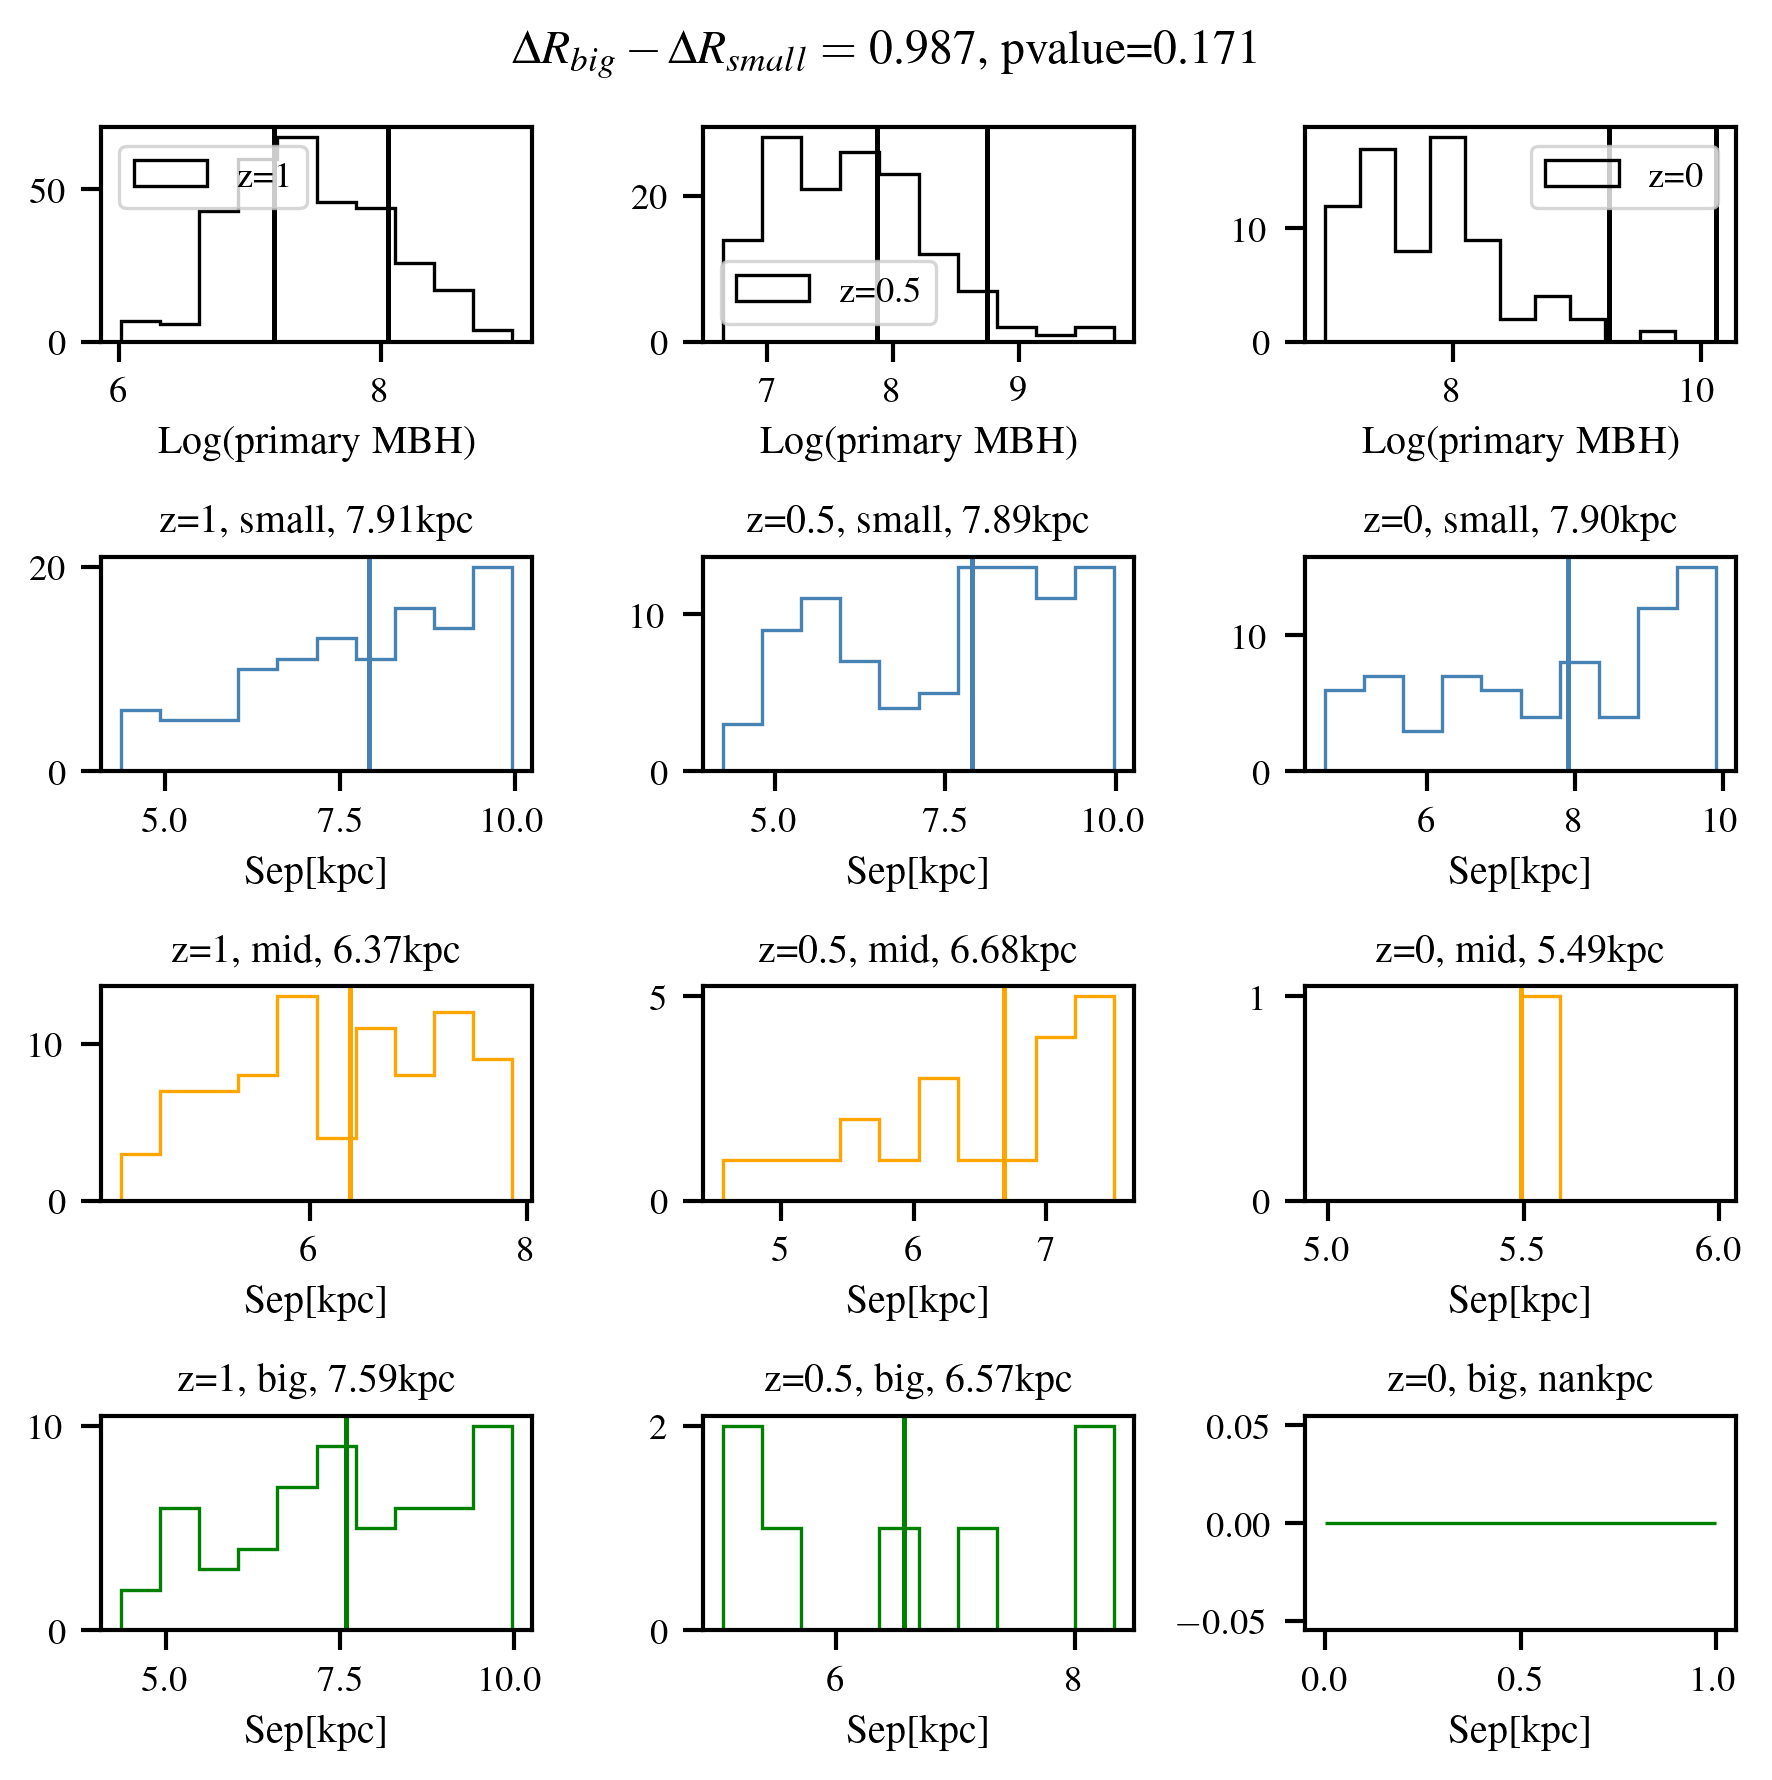

In [ ]:
fig,ax = plt.subplots(4,3,figsize=(6,6),dpi=300)

m_growth = (pure05.logMBH1.min()-pure1.logMBH1.min() + pure05.logMBH1.max()-pure1.logMBH1.max())/2
cuts1 = np.percentile(pure05['logMBH1'],[25,75])
cuts05 = cuts1+m_growth
cuts0 = cuts05+2*m_growth#np.percentile(pure0['logMBH1'],[25,75])
colors = ['steelblue', 'orange', 'green']

for cat,a,lab,c in zip([pure1,pure05,pure0],ax[0,:],['z=1','z=0.5',"z=0"],[cuts1,cuts05,cuts0]):
    cat['logMBH1'].hist(ax=a,histtype='step',label=lab,grid=False,color='k')
    [a.axvline(i,color='k') for i in c]


def quart_mask(quant,cuts):
    mask = []
    mask.append(quant<cuts[0])
    if len(cuts)!= 1:
        for i in range(len(cuts)-1):
            mask.append( ( (quant>cuts[i]) & (quant<cuts[i+1]) ) )
    mask.append(quant>cuts[-1])
    return mask

def quart_mask_o(quant,cuts):
    mask = []
    for i in range(len(cuts)-1):
        mask.append( ( (quant>cuts[i]) & (quant<cuts[i+1]) ) )
    return mask

# define diff of medians
def med_diff(rsmall_e,rsmall_l,rbig_e,rbig_l,axis):
    diffbigM = np.median(rbig_e,axis=axis) - np.median(rbig_l,axis=axis)
    diffsmallM = np.median(rsmall_e,axis=axis) - np.median(rsmall_l,axis=axis)
    return diffbigM - diffsmallM


# get separation in each mass bin
r1 = []
r05 = []
r0 = []

for a, quant, cuts, title, r in zip([ax[1:,0],ax[1:,1],ax[1:,2]],[pure1,pure05,pure0],[cuts1,cuts05,cuts0],['z=1','z=0.5',"z=0"],[r1,r05,r0]):
    mask = quart_mask(quant.logMBH1, cuts)
    q1,q2,q3 = [quant.sep[m] for m in mask]
    r.extend([q1,q3])
    medians = [np.median(q) for q in [q1,q2,q3]]
    [axx.hist(q,histtype='step',color=clr) for axx,q,clr in zip(a,[q1,q2,q3],colors)]
    [axx.axvline(med, color=clr) for axx,med,clr in zip(a,medians,colors)]
    # [axx.set_xlim(4,11) for axx in a]
    # [axx.set_ylim(0,30) for axx in a]
    [axx.set_title(f"{title}, {lab}, {med:.2f}kpc") for axx,lab,med in zip(a,['small','mid','big'],medians)]

[a.set_xlabel("Log(primary MBH)") for a in ax[0,:]]
[a.set_xlabel("Sep[kpc]") for a in ax[1:,:].ravel()]
[a.legend() for a in ax[0,:]]

# do permutation test
res = permutation_test((r1[0],r05[0],r1[1],r05[1]), statistic=med_diff, vectorized=True,alternative='greater')
fig.suptitle(f"$\Delta R_{{big}} - \Delta R_{{small}} = $ {res.statistic:.3f}, pvalue={res.pvalue:.3f}")


fig.tight_layout();


In [72]:
abig_bigM = np.linspace(90,100,10)
asmall_bigM = np.linspace(1,10,10)

abig_smallM = np.linspace(90,100,10)*10
asmall_smallM = np.linspace(1,10,10)*10
permutation_test((abig_smallM,asmall_smallM,abig_bigM,asmall_bigM),
                 med_diff,vectorized=True,alternative='less')

PermutationTestResult(statistic=-805.5, pvalue=0.0119, null_distribution=array([ -66.55555556,   15.        , -486.66666667, ...,   33.88888889,
        -32.77777778,   51.11111111]))

### varstro data

In [4]:
with open("/home/insepien/research-data/df/varsFR.txt", "r") as f:
    vars = [a.rstrip().split("\t") for a in f.readlines()]

vardf = pd.DataFrame(vars[2:],columns=vars[0]) 

sep = vardf['r _p'].values.astype(float)

# separate magnitudes of main and secondary
big_m475, small_m475 = separate_mag(vardf['F475W'])

redshifts = np.array([float(z.split("^")[0]) if z[-1]=="r" else float(z) for z in vardf['Redshift']])
lum475b = cal_lum(big_m475,4750,redshifts)
lum475a = cal_lum(small_m475,4750,redshifts)

# # checking the first object luminosity with WISE, close?
# obs_flux = 3.80E-2*u.Jy
# obs_hz = 1.36E+13*u.Hz
# lum = (obs_flux*obs_hz*4*np.pi*
#         cosmo.luminosity_distance(0.7)**2).to(u.erg/u.s)
# lum*10, (lum475a+lum475b)[0]*1000
vdf = pd.DataFrame([redshifts,sep,vardf['Classification']],index=['z','sep','type']).T

/home/insepien/miniconda3/envs/usc/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/insepien/miniconda3/envs/usc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_924/2818635591.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout();


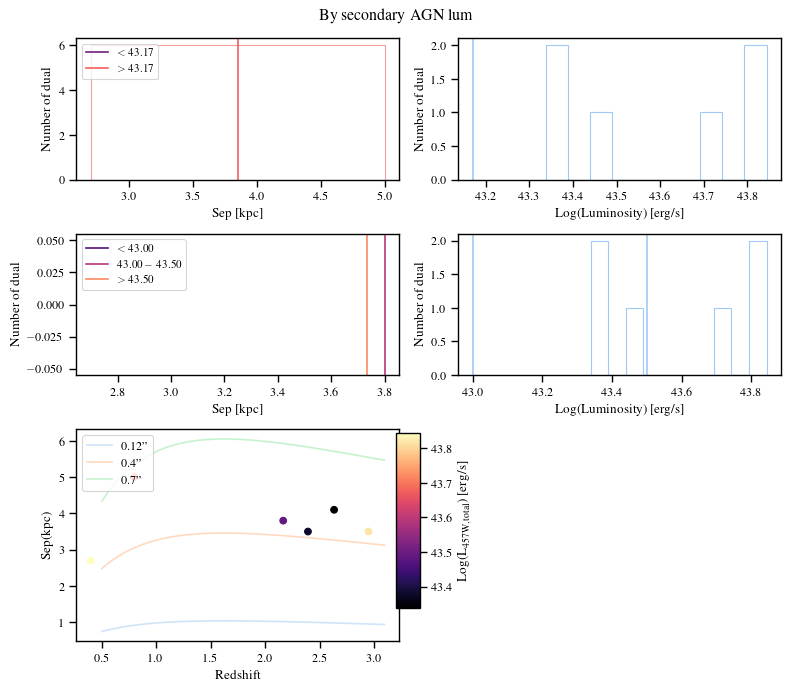

In [7]:
fig,ax = plt.subplots(3,2,gridspec_kw={'height_ratios': [1,1,1.5]},figsize=(8,7))#,dpi=200)

# masks for varstro paper
b =  np.array([a[-2:]=="^b" for a in vardf['Classification']]) # chen22, star based on gemini spectra
c = np.array([a[-2:]=="^c" for a in vardf['Classification']]) # chen22, star based on sdss spectra
chen24star = vardf['Classification'].str.contains("star chen24") # chen 24
gross24single =  vardf['Classification'].str.contains("gross24") # chen 24
zmax = redshifts.max()
zmin = 0.5
zmask = (redshifts> zmin) & (redshifts<zmax)
dualmask = vardf['Classification'].str.contains("dual")
#dualmask = ~chen24star & ~gross24single & zmask
#dualmask = ~ vardf['Classification'].str.contains("star")
#dualmask = np.array([True]*len(vdf))

quant = np.log10((lum475b).value)
cuts0 = []
cuts1 = [43,43.5]
meas_df(sep,[50],quant,ax[0,:],dualmask,cuts0)
meas_df(sep,[25,75],quant,ax[1,:],dualmask,cuts1)


zarr = np.linspace(zmin,zmax)
hstRes = ((0.04*3*u.arcsec).to(u.rad).value*cosmo.angular_diameter_distance(zarr)).to(u.kpc).value
ax[-1,0].plot(zarr,hstRes,alpha=0.5,label="0.12''")
gaiaRes = ((0.4*u.arcsec).to(u.rad).value*cosmo.angular_diameter_distance(zarr)).to(u.kpc).value
ax[-1,0].plot(zarr,gaiaRes,alpha=0.5,label="0.4''")
gaiaResUp = ((0.7*u.arcsec).to(u.rad).value*cosmo.angular_diameter_distance(zarr)).to(u.kpc).value
ax[-1,0].plot(zarr,gaiaResUp,alpha=0.5,label="0.7''")


sca = ax[-1,0].scatter(redshifts[dualmask],sep[dualmask], cmap="magma",c=quant[dualmask])
cax = fig.add_axes([0.5, 0.125, 0.03, 0.25])
cbar = fig.colorbar(sca,cax=cax)
cbar.set_label("Log(L$_{\\rm{457 W, total}}$) [erg/s]")
ax[-1,0].set_xlabel("Redshift")
ax[-1,0].set_ylabel("Sep(kpc)")
ax[-1,0].legend();
ax[-1,-1].axis("off")

fig.suptitle("By secondary AGN lum")
fig.tight_layout();


### observed sep hist

In [4]:
bigmac = pd.read_csv("/home/insepien/research-data/GFG.csv")
# create masks
positive_sep = bigmac['Sep(kpc)'] > 0 
dual_sep = (bigmac['Sep(kpc)']>0.1 ) #& (bigmac['Sep(kpc)']<20)
confd = bigmac['ST1 Confidence Flag']>=0
radio = bigmac['Parsed Analysis Method'].str.contains("Radio")
imaging = bigmac['Parsed Analysis Method'].str.contains("Imaging")
# get papers with largest sample
pp = []
for i in bigmac['Paper(s)']:
    [pp.append(j) for j in i.split(" ; ")]
paper_dict = Counter(pp).most_common()

In [ ]:
def norm_hist(ax,quant,fcolor,ecolor,bin_arr,lbl):
    """normalize histogram sum count to 1 given some quantity (quant)
        args: edgecoloe, facecolor, bin array, opacity, flag for plotting horizontal hist"""
    count, bin = np.histogram(quant,bins=bin_arr)
    ax.bar(bin[:-1],count/np.sum(count),width = np.diff(bin),align='edge',facecolor=fcolor,edgecolor=ecolor,label=lbl)
    #ax.plot(bin[:-1],count/np.sum(count),c=ecolor)
    
def plot_sep_hist(npaper, upsep):
    fig,ax = plt.subplots(npaper//5,5,figsize=(12,3*npaper//5),sharex=True, sharey=True)
    ax = ax.ravel()
    upsepvar = np.max(vard)
    numbin = int(np.sqrt(len(vard)))
    bins_vard = np.linspace(np.min(vard),upsepvar,numbin)
    bins = np.diff(bins_vard)[0]*np.arange(upsep)+1
    cls = sns.color_palette("colorblind", 10)
    small_sep = bigmac['Sep(kpc)']< upsep
    for p,a in zip(paper_dict[:npaper+1],ax):
        mask = [np.isin(p[0],i.split(" ; ")) == True for i in bigmac['Paper(s)']]
        #plt.hist(bigmac[mask&positive_sep]['Sep(kpc)'],histtype="step",label=p[0])
        norm_hist(a,vard,"darkseagreen","darkseagreen",bins,'varstro')
        norm_hist(a,bigmac[mask & positive_sep & small_sep]['Sep(kpc)'],"none","blue",bins,p[0])
        a.legend()
    fig.tight_layout();


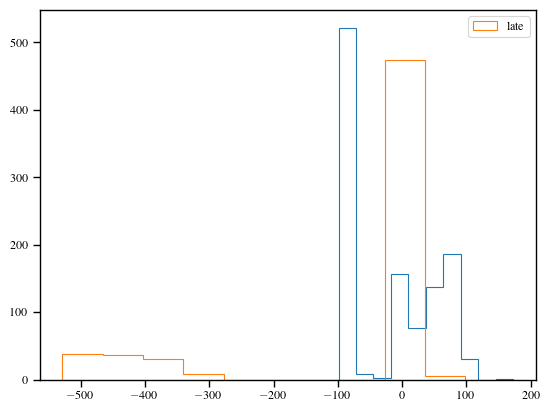

In [12]:
early = (bigmac["z1"] < 0.05)
late = (bigmac["z1"] > 0.2) & (bigmac["z1"] < 0.4)
plt.hist(bigmac['Sep(kpc)'][early],histtype='step')
plt.hist(bigmac['Sep(kpc)'][late],histtype='step',label='late')
plt.legend();